In [26]:
import numpy as np

In [27]:
dir = '/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train'

In [28]:
import os
classes = os.listdir(dir)

In [29]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
files = {}
for class_name in os.listdir(dir):
    class_path = os.path.join(dir, class_name)
    if not os.path.isdir(class_path):
        continue
    print(class_path)
    files[class_name] = [f for f in os.listdir(class_path)]

/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/buildings
/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/forest
/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/glacier
/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/mountain
/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/sea
/media/smayan/500GB SSD/Study/ML2/Practicals/Data/Intel Image Data/seg_train/seg_train/street


In [46]:
import glob
from PIL import Image
import numpy as np

def iter_image_paths(root_dir, exts=(".jpg", ".jpeg", ".png", ".bmp")):
    """Yield (path, class_name) for images under root_dir/class_name/*."""
    class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    class_names.sort()
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        for ext in exts:
            for path in glob.glob(os.path.join(class_dir, f"*{ext}")):
                yield path, class_name

def load_image_pil(path, size=(150, 150), mode="RGB"):
    """Load an image as a NumPy array using PIL (no TensorFlow)."""
    with Image.open(path) as img:
        img = img.convert(mode)
        if size is not None:
            img = img.resize(size)
        arr = np.asarray(img, dtype=np.uint8)
    return arr

def load_folder_dataset(root_dir, size=(150, 150), max_per_class=None, normalize=False):
    """
    Load images from a folder structured as:
      root_dir/
        classA/*.jpg
        classB/*.jpg
    Returns: X (N,H,W,C), y (N,), class_to_index (dict).
    """
    class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    class_names.sort()
    class_to_index = {name: i for i, name in enumerate(class_names)}

    X_list = []
    y_list = []
    per_class_count = {name: 0 for name in class_names}

    for path, class_name in iter_image_paths(root_dir):
        if class_name not in class_to_index:
            continue
        if max_per_class is not None and per_class_count[class_name] >= max_per_class:
            continue
        try:
            arr = load_image_pil(path, size=size, mode="RGB")
        except Exception as e:
            # Skip unreadable/corrupt files
            continue
        X_list.append(arr)
        y_list.append(class_to_index[class_name])
        per_class_count[class_name] += 1

    if len(X_list) == 0:
        raise ValueError(f"No images found under: {root_dir}")

    X = np.stack(X_list, axis=0)
    y = np.asarray(y_list, dtype=np.int64)
    if normalize:
        X = X.astype(np.float32) / 255.0
    return X, y, class_to_index

# Example: limit per class to avoid OOM; set max_per_class=None to load everything
X, y, class_to_index = load_folder_dataset(dir, size=(150, 150), max_per_class=200, normalize=False)
X.shape, y.shape, class_to_index

((1200, 150, 150, 3),
 (1200,),
 {'buildings': 0,
  'forest': 1,
  'glacier': 2,
  'mountain': 3,
  'sea': 4,
  'street': 5})

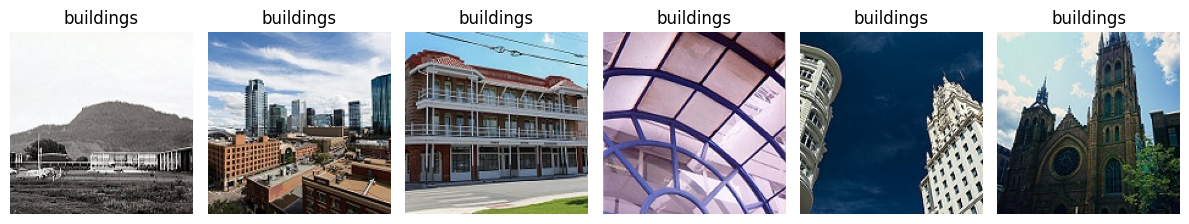

In [47]:
import matplotlib.pyplot as plt

# Quick sanity check: show a few samples
inv_map = {v: k for k, v in class_to_index.items()}
n_show = min(6, len(X))
plt.figure(figsize=(12, 4))
for i in range(n_show):
    plt.subplot(1, n_show, i + 1)
    plt.imshow(X[i])
    plt.title(inv_map[int(y[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()